Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 2017/2018  
http://www.fer.unizg.hr/predmet/su

------------------------------

### Laboratorijska vježba 4: Ansambli i procjena parametara

*Verzija: 0.1  
Zadnji put ažurirano: 11. prosinca 2017.*

(c) 2015-2017 Jan Šnajder, Domagoj Alagić  

Objavljeno: **11. prosinca 2017.**  
Rok za predaju: **18. prosinca 2017. u 07:00h**

------------------------------

Objavljeno: **6. prosinca 2016.**<br>
Rok za predaju: U terminu vježbe u tjednu od **12. prosinca 2016.**

### Upute

Četvrta laboratorijska vježba sastoji se od **četiri** zadatka. Kako bi kvalitetnije, ali i na manje zamoran način usvojili gradivo ovog kolegija, potrudili smo se uključiti tri vrste zadataka: **1)** implementacija manjih algoritama, modela ili postupaka; **2)** eksperimenti s raznim modelima te njihovim hiperparametrima, te **3)** primjena modela na (stvarnim) podatcima. Ovim zadatcima pokrivamo dvije paradigme učenja: učenje izgradnjom (engl. *learning by building*) i učenje eksperimentiranjem (engl. *learning by experimenting*).

U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import mlutils
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier


def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.02  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

def plot_2d_svc_problem(X, y, svc=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if SVC object is given, 
    the decision surfaces (with margin as well).
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if svc!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        Z = np.array([svc_predict(svc, x) for x in XX])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.Paired, marker='o', s=50)
    #plt.show()

def svc_predict(svc, x) : 
    h = svc.decision_function([x])
    if h >= -1 and h <= 1:
        return 0.5
    else: 
        return max(-1, min(1, h))

def plot_error_surface(err, c_range=(0,5), g_range=(0,5)):
    c1, c2 = c_range[0], c_range[1]
    g1, g2 = g_range[0], g_range[1]
    plt.xticks(range(0,g2-g1+1,5),range(g1,g2,5)); plt.xlabel("gamma")
    plt.yticks(range(0,c2-c1+1,5),range(c1,c2,5)); plt.ylabel("C")
    p = plt.contour(err);
    plt.imshow(1-err, interpolation='bilinear', origin='lower',cmap=plt.cm.gray)
    plt.clabel(p, inline=1, fontsize=10)
    #plt.show()


def knn_eval(n_instances=100, n_features=2, n_classes=2, n_informative=2, 
             test_size=0.3, k_range=(1, 20), n_trials=100):
    
    train_errors = []
    test_errors = []
    ks = list(range(k_range[0], k_range[1] + 1))

    for i in range(0, n_trials):
        X, y = make_classification(n_instances, n_features, n_classes=n_classes, 
                                   n_informative=n_informative, n_redundant=0, n_clusters_per_class=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        train = []
        test = []
        for k in ks:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            train.append(1 - knn.score(X_train, y_train))
            test.append(1 - knn.score(X_test, y_test))
        train_errors.append(train)
        test_errors.append(test)
        
    train_errors = np.mean(np.array(train_errors), axis=0)
    test_errors = np.mean(np.array(test_errors), axis=0)
    best_k = ks[np.argmin(test_errors)]
    
    return ks, best_k, train_errors, test_errors

### 1. Ansambli (glasovanje)

#### (a)

Vaš je zadatak napisati razred `VotingClassifierDIY` koji implementira glasački ansambl. Konstruktor razreda ima **dva** parametra: `clfs` koji predstavlja listu klasifikatora (objekata iz paketa `sklearn`) i `voting_scheme` koji označava radi li se o glasovanju prebrojavanjem (`SCHEME_COUNTING`) ili usrednjavanjem (`SCHEME_AVERAGING`). Glasovanje prebrojavanjem jednostavno vraća najčešću oznaku klase, dok glasovanje usrednjavanjem uprosječuje pouzdanosti klasifikacije u neku klasu (po svim klasifikatorima) te vraća onu s najvećom pouzdanošću. Primijetite da svi klasifikatori imaju jednake težine. O komplementarnosti klasifikatora vodimo računa tako da koristimo jednake klasifikatore s različitim hiperparametrima.

Razred sadržava metode `fit(X, y)` za učenje ansambla i dvije metode za predikciju: `predict(X)` i `predict_proba(X)`. Prva vraća predviđene oznake klasa, a druga vjerojatnosti pripadanja svakoj od klasa za svaki od danih primjera iz `X`.

**NB:** Jedan od razreda koji bi Vam mogao biti koristan jest [`collections.Counter`](https://docs.python.org/2/library/collections.html#collections.Counter). Također vrijedi i za funkcije [`numpy.argmax`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) i [`numpy.dstack`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html).

In [85]:
from collections import Counter

class VotingClassifierDIY(object):
    
    SCHEME_COUNTING = "counting"
    SCHEME_AVERAGING = "averaging"
    
    def __init__(self, clfs, voting_scheme=SCHEME_COUNTING):
        self.clfs = clfs
        self.voting = voting_scheme
        
        
    def fit(self, X, y):
        
        for clf in self.clfs:
            clf.fit(X,y)
    
    def predict_proba(self, X):
        n1, m1 = X.shape
        n2 = len(self.clfs)
        solution = []
        
        if(self.voting == "averaging"):
            y_pred_1 = np.zeros((n1,n2))
            for clf in self.clfs:
                y_pred_1[:,:]+=clf.predict_proba(X)
            solution =  np.array(list(np.divide(y_pred_1,len(self.clfs))))                                                        
        else:
            y_pred = np.zeros((n1,n2))
            index = 0
            for clf in self.clfs:
                y_pred[:, index]=clf.predict(X)
                index+=1
            y_prediction = np.zeros((n1,len(np.unique(y_pred))))



            for i in range(0,n1):
                c = Counter(y_pred[i,:])
                index = 0
                for y in sorted(np.unique(y_pred)):
                    y_prediction[i,index] = c[y]/len(np.unique(y_pred))
                    index +=1
        
            solution = np.array(list(y_prediction))
    
        return solution
    def predict(self, X):
        n1, m1 = X.shape
        n2 = len(self.clfs)
        if(self.voting ==  "averaging"):
            y_pred_1 = np.zeros((n1,n2))
            for clf in self.clfs:
                y_pred_1[:,:]=y_pred_1[:,:]+clf.predict_proba(X)

            return np.argmax(np.array(list(np.divide(y_pred_1,len(self.clfs)))), axis=1)
        
        n1, m1 = X.shape
        n2 = len(self.clfs)
        y_pred = np.zeros((n1,n2))
        index = 0
        for clf in self.clfs:
            y_pred[:, index]=clf.predict(X)
            index+=1
        y_prediction = np.zeros((n1,len(np.unique(y_pred))))
        
       
        for i in range(0,n1):
            c = Counter(y_pred[i,:])
            index = 0
            for y in sorted(np.unique(y_pred)):
                y_prediction[i,index] = c[y]
                index +=1
                    
                       
        return np.argmax(np.array(list(y_prediction)), axis=1)

#### (b)

Uvjerite se da Vaša implementacija radi jednako onoj u razredu [`ensemble.VotingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html), i to pri oba načina glasovanja (parametar `voting`). Parametar `weights` ostavite na pretpostavljenoj vrijednosti. Za ovu provjeru koristite tri klasifikatora logističke regresije s različitom stopom regularizacije i brojem iteracija. Koristite skup podataka dan u nastavku. Ekvivalentnost implementacije najlakše je provjeriti usporedbom izlaza funkcije `predict` (kod prebrojavanja) i funkcije `predict_proba` (kod usrednjavanja).

**NB:** Ne koristimo SVM jer njegova ugrađena (probabilistička) implementacija nije posve deterministička, što bi onemogućilo robusnu provjeru Vaše implementacije.

In [15]:
from sklearn.datasets import make_classification
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

X_voting, y_voting = make_classification(n_samples=1000, n_features=4, n_redundant=0, n_informative=3, n_classes=3, n_clusters_per_class=2)

In [89]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

clfs = []
lr1 = LogisticRegression(C=0.001, max_iter = 8000)
lr2 = LogisticRegression(C=0.1, max_iter = 10000)
lr3 = LogisticRegression(C=12.02, max_iter = 5000)
clfs.append(lr1)
clfs.append(lr2)
clfs.append(lr3)

X_voting_train,X_voting_test, y_voting_train, y_voting_test = train_test_split(X_voting, y_voting, train_size=0.7, random_state=69)

sklearn_voting_hard = VotingClassifier(estimators=[('lr1', lr1),('lr2', lr2),('lr3', lr3)], voting='hard')
sklearn_voting_hard.fit(X_voting_train, y_voting_train)
print("Sklearn counting test error is {} and tarin error is {}".format(accuracy_score(y_voting_test, sklearn_voting_hard.predict(X_voting_test)),accuracy_score(y_voting_train, sklearn_voting_hard.predict(X_voting_train))))

vot_couting = VotingClassifierDIY(clfs,"counting")
vot_couting.fit(X_voting_train, y_voting_train)
print("My counting test error is {} and tarin error is {}".format(accuracy_score(y_voting_test, vot_couting.predict(X_voting_test)),accuracy_score(y_voting_train, vot_couting.predict(X_voting_train))))

sklearn_voting_soft = VotingClassifier(estimators=[('lr1', lr1),('lr2', lr2),('lr3', lr3)], voting='soft')
sklearn_voting_soft.fit(X_voting_train, y_voting_train)
print("Sklearn averaging test error is {} and tarin error is {}".format(accuracy_score(y_voting_test, sklearn_voting_soft.predict(X_voting_test)),accuracy_score(y_voting_train, sklearn_voting_soft.predict(X_voting_train))))

vot_avg = VotingClassifierDIY(clfs,"averaging")
vot_avg.fit(X_voting_train, y_voting_train)
print("My averaging test error is {} and tarin error is {}".format(accuracy_score(y_voting_test, vot_avg.predict(X_voting_test)),accuracy_score(y_voting_train, vot_avg.predict(X_voting_train))))
print("Arrays are equal {}".format(np.array_equal(vot_avg.predict_proba(X_voting_test),sklearn_voting_soft.predict_proba(X_voting_test))))
print("{} \n {}".format( vot_avg.predict_proba(X_voting_test)[:20,:], sklearn_voting_soft.predict_proba(X_voting_test)[:20,:]))


Sklearn counting test error is 0.6333333333333333 and tarin error is 0.6485714285714286
My counting test error is 0.6333333333333333 and tarin error is 0.6485714285714286
Sklearn averaging test error is 0.63 and tarin error is 0.6471428571428571
My averaging test error is 0.63 and tarin error is 0.6471428571428571
Arrays are equal True
[[ 0.35580084  0.44409827  0.20010089]
 [ 0.19138634  0.54822056  0.2603931 ]
 [ 0.2713483   0.26428099  0.46437072]
 [ 0.40970633  0.34566414  0.24462953]
 [ 0.31835531  0.47071787  0.21092683]
 [ 0.38289739  0.34951156  0.26759105]
 [ 0.51426071  0.14529153  0.34044775]
 [ 0.18658496  0.34172203  0.47169301]
 [ 0.36732999  0.16451806  0.46815195]
 [ 0.53129309  0.11942224  0.34928468]
 [ 0.42996277  0.13086553  0.4391717 ]
 [ 0.3359234   0.3866053   0.2774713 ]
 [ 0.17837582  0.47720646  0.34441772]
 [ 0.10678595  0.57528528  0.31792877]
 [ 0.68558128  0.11653063  0.1978881 ]
 [ 0.1116913   0.56418907  0.32411963]
 [ 0.24704295  0.2280509   0.52490615]

**Q:** Kada je prebrojavanje bolje od usrednjavanja? Zašto? A obratno?  
**Q:** Bi li se ovakav algoritam mogao primijeniti na regresiju? Kako?

### 2. Ansambli (*bagging*)

U ovom zadatku ćete isprobati tipičnog predstavnika *bagging*-algoritma, **algoritam slučajnih šuma**. Pitanje na koje želimo odgovoriti jest kako se ovakvi algoritmi nose s prenaučenošću, odnosno, smanjuje li *bagging* varijancu modela.

Eksperiment ćete provesti na danom skupu podataka:

In [29]:
from sklearn.cross_validation import train_test_split

X_bag, y_bag = make_classification(n_samples=1000, n_features=20, n_redundant=1, n_informative=17, n_classes=3, n_clusters_per_class=2)
X_bag_train, X_bag_test, y_bag_train, y_bag_test = train_test_split(X_bag, y_bag, train_size=0.7, random_state=69)

Razred koji implementira stablo odluke jest [`tree.DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Prvo naučite **stablo odluke** (engl. *decision tree*) na skupu za učenje, ali tako da je taj model presložen. To možete postići tako da povećate najveću moguću dubinu stabla (parametar `max_depth`). Ispišite pogrešku na skupu za ispitivanje (pogrešku 0-1; pogledajte paket [`metrics`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)).

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss

decision_tree = DecisionTreeClassifier(max_depth = 50)
decision_tree.fit(X_bag_train, y_bag_train)
loss = zero_one_loss( y_bag_test , decision_tree.predict(X_bag_test))

print("loss of decision tree is: {}".format(loss))

loss of decision tree is: 0.41333333333333333


Sada isprobajte algoritam slučajnih šuma (dostupan u razredu [`ensemble.RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) za različit broj stabala $L \in [1, 30]$. Iscrtajte pogrešku na skupu za učenje i na skupu za ispitivanje u ovisnosti o tom hiperparametru. Ispišite najmanju pogrešku na skupu za ispitivanje.

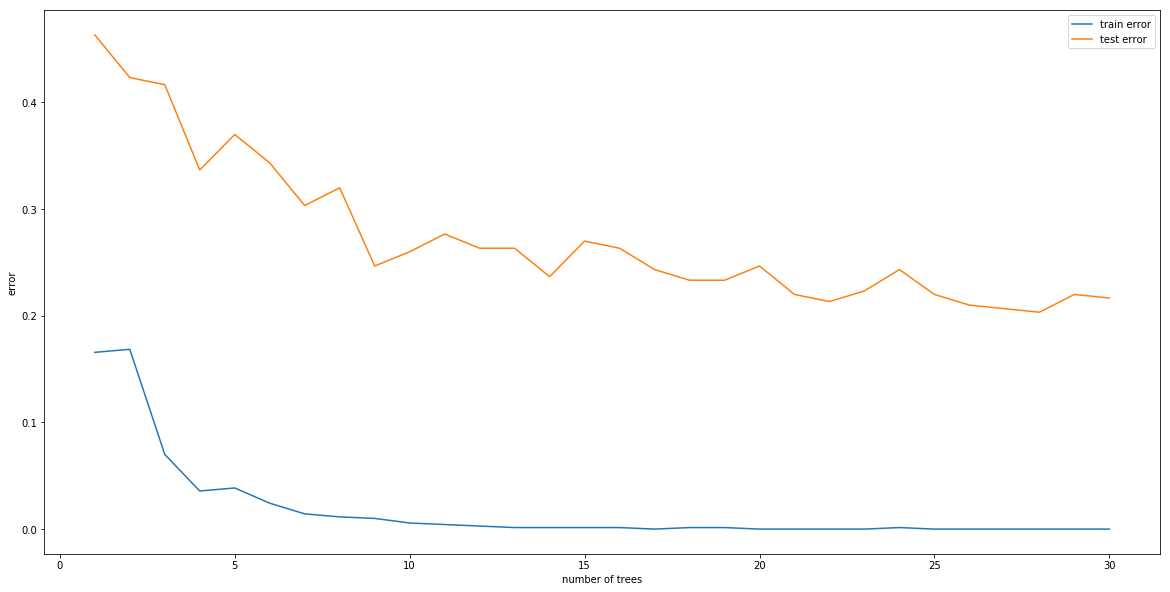

In [33]:
from sklearn.ensemble import RandomForestClassifier

pylab.rcParams['figure.figsize'] = (20, 10)


loss_train = []
loss_test = []
for i in range(1, 31):
    random_forest = RandomForestClassifier(n_estimators=i)
    random_forest.fit(X_bag_train, y_bag_train)
    loss_test.append(zero_one_loss( y_bag_test , random_forest.predict(X_bag_test)))
    loss_train.append(zero_one_loss( y_bag_train , random_forest.predict(X_bag_train)))

loss_train_array = np.array(list(loss_train))
loss_test_array = np.array(list(loss_test))
plt.plot(range(1,31), loss_train_array, label='train error')
plt.plot(range(1,31), loss_test_array, label='test error')
plt.xlabel('number of trees')
plt.ylabel('error')
plt.legend(loc='best')
plt.show()

**Q:** Što možete zaključiti iz ovih grafikona?  
**Q:** Kako *bagging* postiže diverzifikaciju pojedinačnih osnovnih modela?  
**Q:** Koristi li ovaj algoritam složeni ili jednostavni osnovni model? Zašto?

### 3. Ansambli (*boosting*)

U ovom zadatku pogledat ćemo klasifikacijski algoritam AdaBoost, koji je implementiran u razredu [`ensemble.AdaBoostClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). Ovaj algoritam tipičan je predstavnik *boosting*-algoritama.

Najprije ćemo generirati eksperimentalni skup podataka koristeći [`datasets.make_circles`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html). Ova funkcija stvara dvodimenzijski klasifikacijski problem u kojem su dva razreda podataka raspoređena u obliku kružnica, tako da je jedan razred unutar drugog.

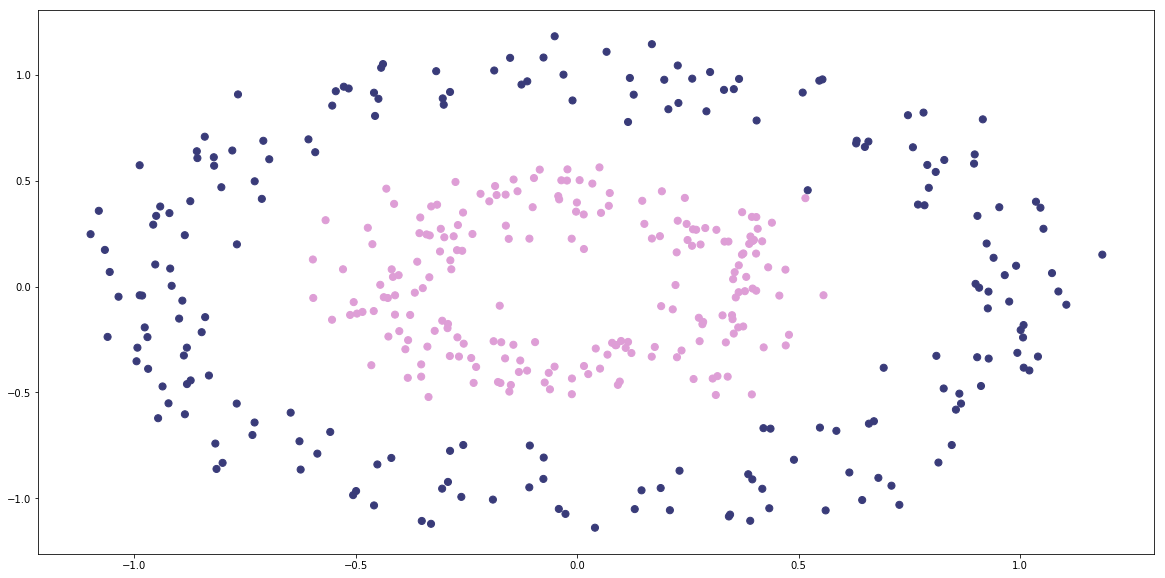

In [34]:
from sklearn.datasets import make_circles
pylab.rcParams['figure.figsize'] = (20, 10)


circ_X, circ_y = make_circles(n_samples=400, noise=0.1, factor=0.4)
plot_2d_clf_problem(circ_X, circ_y)

#### (a)

*Boosting*, kao vrsta ansambla, također se temelji na kombinaciji više klasifikatora s ciljem boljih prediktivnih sposobnosti. Međutim, ono što ovakav tip ansambla čini zanimljivim jest to da za osnovni klasifikator traži **slabi klasifikator** (engl. *weak classifier*), odnosno klasifikator koji radi tek malo bolje od nasumičnog pogađanja. Često korišteni klasifikator za tu svrhu jest **panj odluke** (engl. *decision stump*), koji radi predikciju na temelju samo jedne značajke ulaznih primjera. Panj odluke specijalizacija je **stabla odluke** (engl. *decision tree*) koje smo već spomenuli. Panj odluke stablo je dubine 1. Stabla odluke implementirana su u razredu [`tree.DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

Radi ilustracije, naučite ansambl (AdaBoost) koristeći panj odluke kao osnovni klasifikator, ali pritom isprobavajući različit broj klasifikatora u ansamblu iz skupa $L \in \{1, 2, 3, 50\}$. Prikažite decizijske granice na danom skupu podataka za svaku od vrijednosti korištenjem pomoćne funkcije `mlutils.plot_2d_clf_problem`.

**NB:** Još jedan dokaz da hrvatska terminologija zaista može biti smiješna. :)

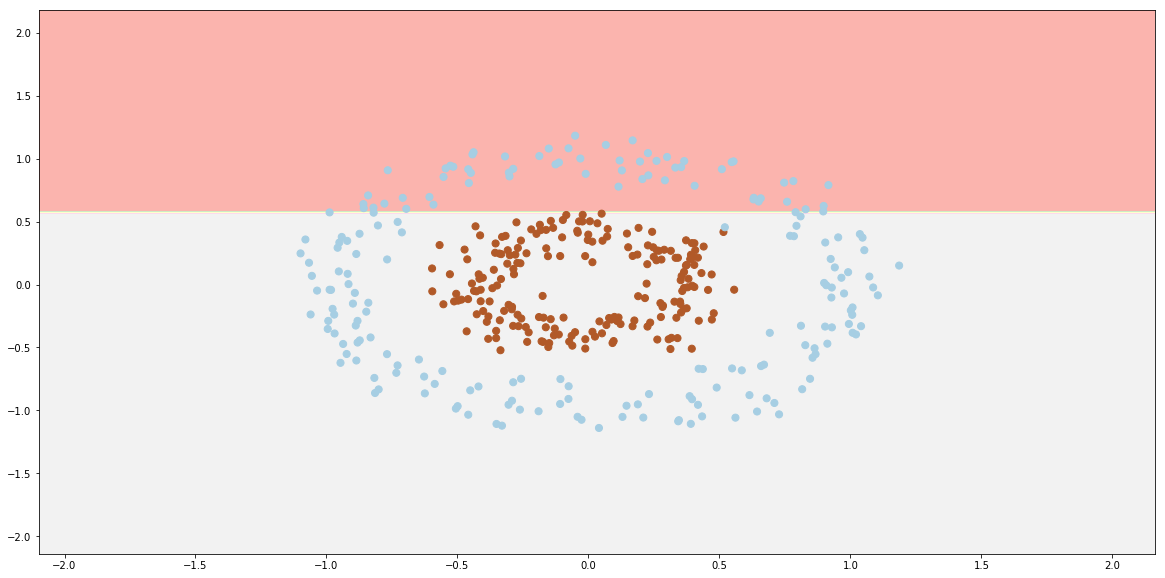

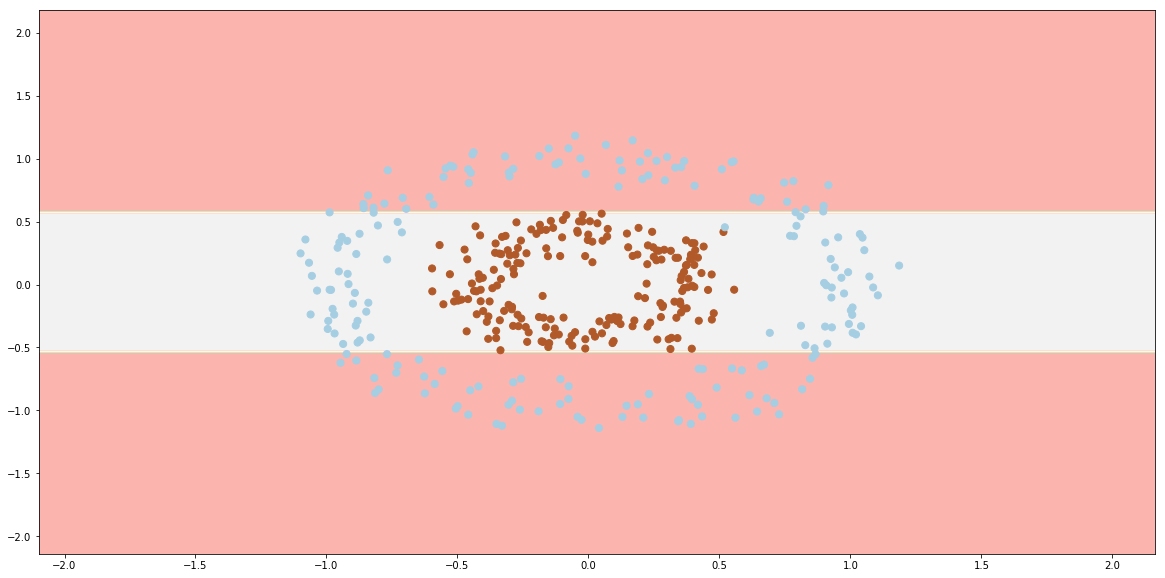

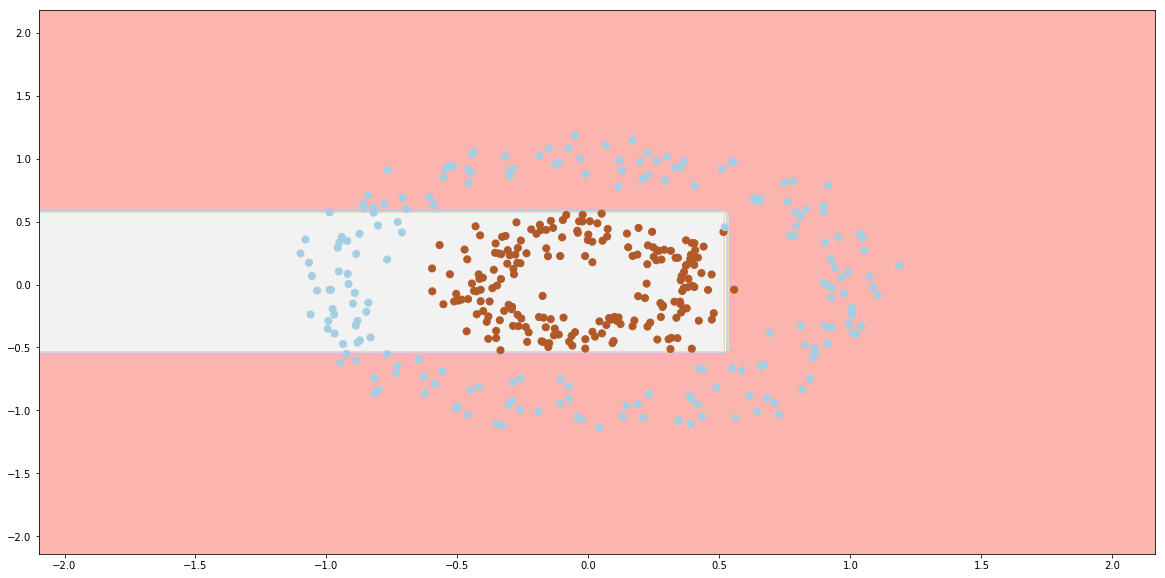

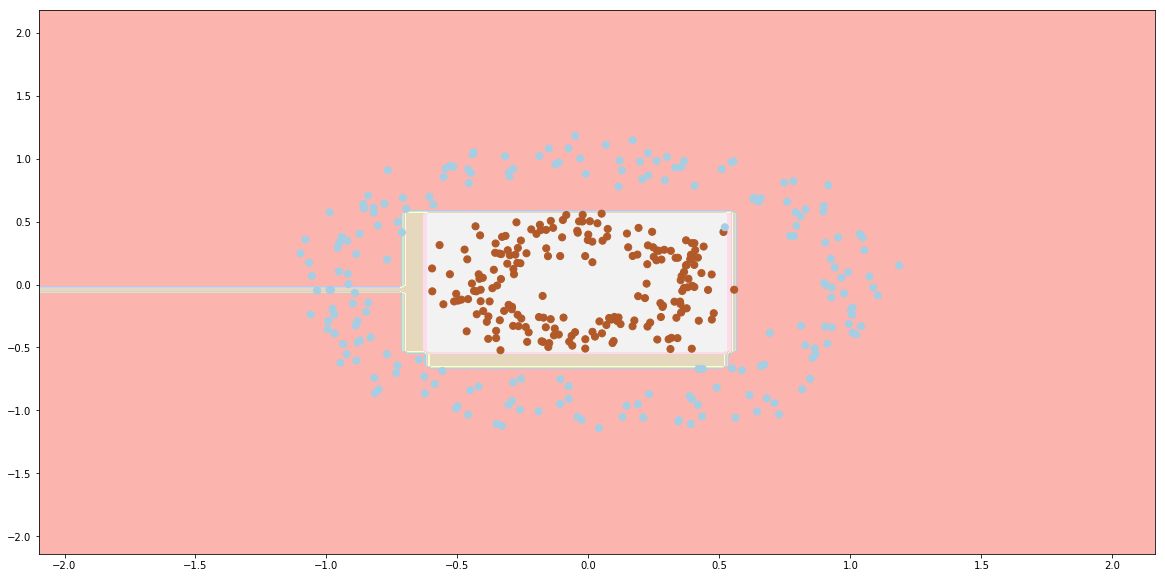

In [35]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

for i in [1,2,3,50]:
    adaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth =1) , n_estimators=i)
    adaBoost.fit(circ_X, circ_y)
    plot_2d_svc_problem(circ_X, circ_y, adaBoost)
    plt.show()

**Q:** Kako AdaBoost radi? Ovise li izlazi pojedinih osnovnih modela o onima drugih?  
**Q:** Je li AdaBoost linearan klasifikator? Pojasnite.

#### (b)

Kao što je i za očekivati, broj klasifikatora $L$ u ansamblu predstavlja hiperparametar algoritma *AdaBoost*. U ovom zadatku proučit ćete kako on utječe na generalizacijsku sposobnost Vašeg ansambla. Ponovno, koristite panj odluke kao osnovni klasifikator.

Poslužite se skupom podataka koji je dan niže.

In [36]:
from sklearn.cross_validation import train_test_split

X_boost, y_boost = make_classification(n_samples=1000, n_features=20, n_redundant=0, n_informative=18, n_classes=3, n_clusters_per_class=1)
X_boost_train, X_boost_test, y_boost_train, y_boost_test = train_test_split(X_boost, y_boost, train_size=0.7, random_state=69)

Iscrtajte krivulje pogrešaka na skupu za učenje i ispitivanje u ovisnosti o hiperparametru $L \in [1,80]$. Koristite pogrešku 0-1 iz paketa [`metrics`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). Ispišite najmanju ostvarenu pogrešku na skupu za ispitivanje, te pripadajuću vrijednost hiperparametra $L$.

minimal error is 0.22999999999999998 for L = 80


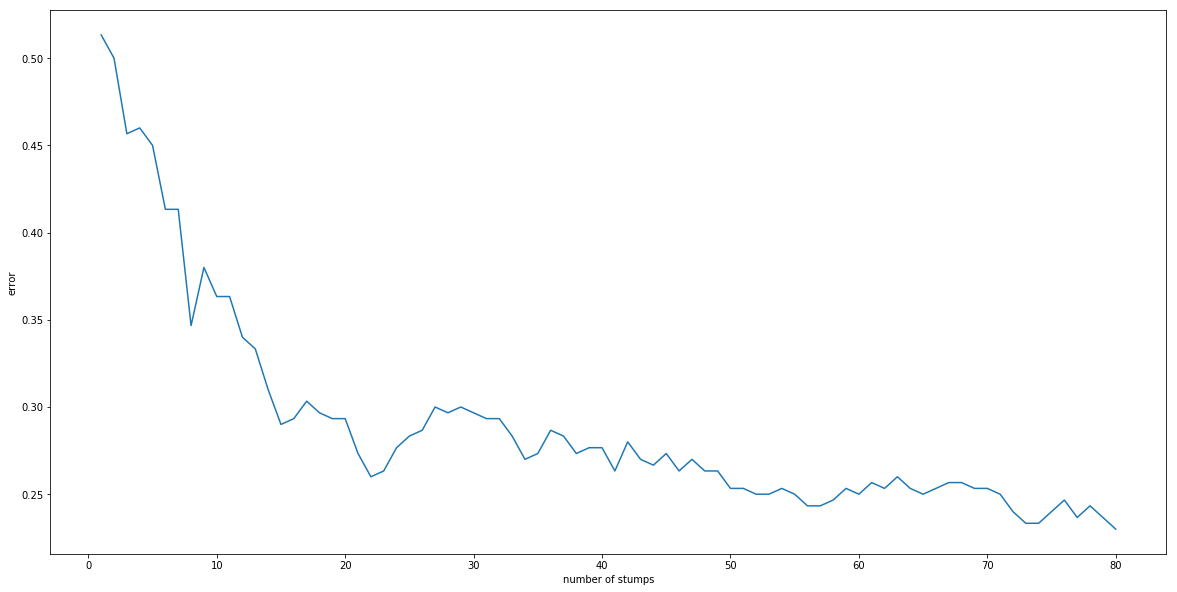

In [37]:
from sklearn.metrics import zero_one_loss

loss= []
for i in range(1,81):
    adaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth =1) , n_estimators=i)
    adaBoost.fit(X_boost_train, y_boost_train)
    loss.append(zero_one_loss(y_boost_test, adaBoost.predict(X_boost_test)))

loss_array = np.array(list(loss))
print("minimal error is {} for L = {}".format(np.amin(loss_array) , np.argmin(loss_array)+1))
plt.plot(range(1,81), loss_array)
plt.xlabel('number of stumps')
plt.ylabel('error')
plt.show()

**Q:** Može li uopće doći do prenaučenosti pri korištenju *boosting*-algoritama?

#### (c)

Kao što je rečeno na početku, *boosting*-algoritmi traže slabe klasifikatore kako bi bili najefikasniji što mogu biti. Međutim, kako se takav ansambl mjeri s jednim **jakim klasifikatorom** (engl. *strong classifier*)? To ćemo isprobati na istom primjeru, ali korištenjem jednog optimalno naučenog stabla odluke.

Ispišite pogrešku ispitivanja optimalnog stabla odluke. Glavni hiperparametar stabala odluka jest njihova maksimalna dubina $d$ (parametar `max_depth`). Iscrtajte krivulje pogrešaka na skupu za učenje i ispitivanje u ovisnosti o dubini stabla $d \in [1,20]$.

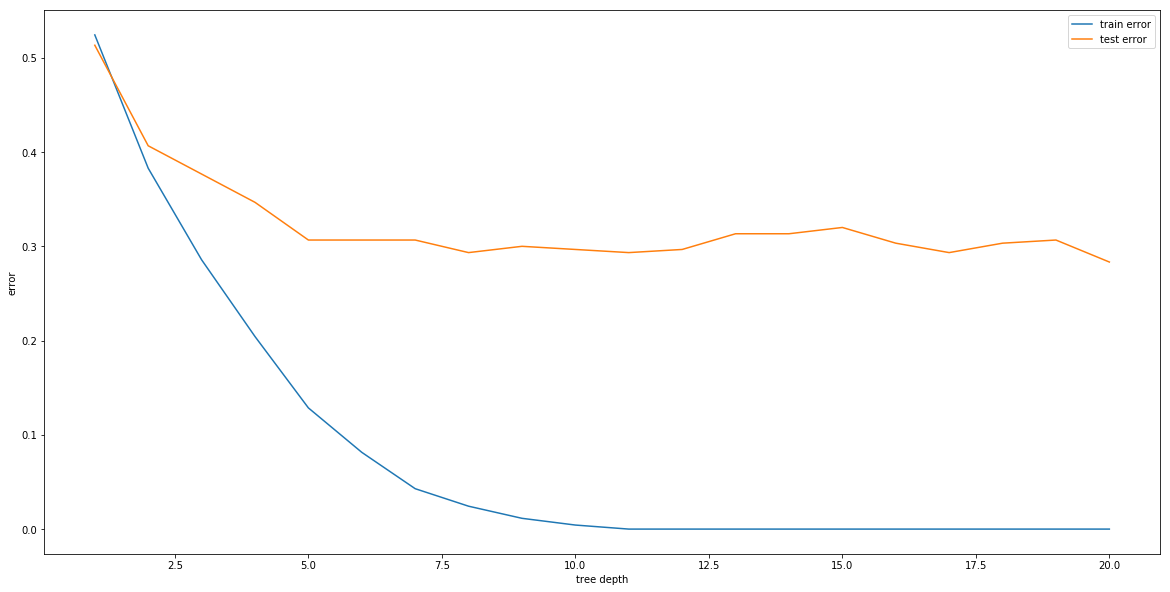

In [38]:
loss_train = []
loss_test = []
 
for i in range(1, 21):
    decision_tree = DecisionTreeClassifier(max_depth =i)
    decision_tree.fit(X_boost_train, y_boost_train)
    loss_test.append(zero_one_loss( y_boost_test , decision_tree.predict(X_boost_test)))
    loss_train.append(zero_one_loss( y_boost_train , decision_tree.predict(X_boost_train)))

loss_train_array = np.array(list(loss_train))
loss_test_array = np.array(list(loss_test))
plt.plot(range(1,21), loss_train_array, label='train error')
plt.plot(range(1,21), loss_test_array, label='test error')
plt.xlabel('tree depth')
plt.ylabel('error')
plt.legend(loc='best')
plt.show()

**Q:** Isplati li se koristiti ansambl u obliku *boostinga*? Idu li grafikoni tome u prilog?<br>
**Q:** Koja je prednost *boostinga* nad korištenjem jednog jakog klasifikatora?

### 4. Procjena maksimalne izglednosti i procjena maksimalne aposteriorne vjerojatnosti

#### (a)

Definirajte funkciju izglednosti $\mathcal{L}(\mu|\mathcal{D})$ za skup $\mathcal{D}=\{x^{(i)}\}_{i=1}^N$ Bernoullijevih varijabli. Neka od $N$ varijabli njih $m$ ima vrijednost 1 (npr. od $N$ bacanja novčića, $m$ puta smo dobili glavu). Definirajte funkciju izglednosti tako da je parametrizirana s $N$ i $m$, dakle definirajte funkciju $\mathcal{L}(\mu|N,m)$. 

In [39]:
def likelihood(mi, N,m):
    return ((mi)**m)*(1-mi)**(N-m)

#### (b)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za (1) $N=10$ i $m=1,2,5,9$ te za (2) $N=100$ i $m=1,10,50,90$ (dva zasebna grafikona).

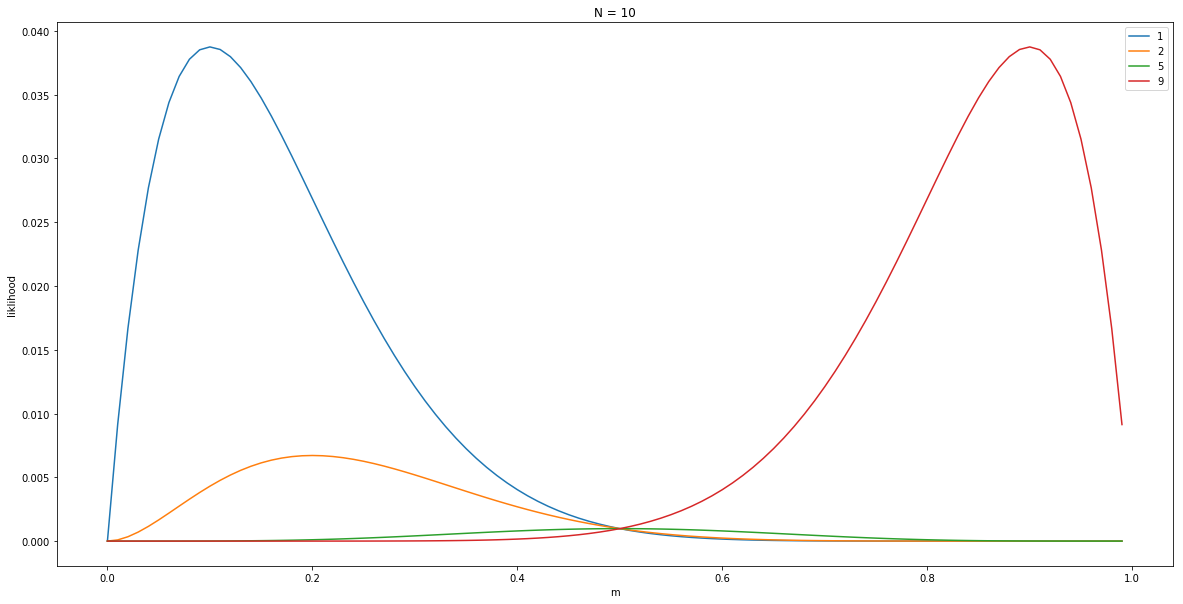

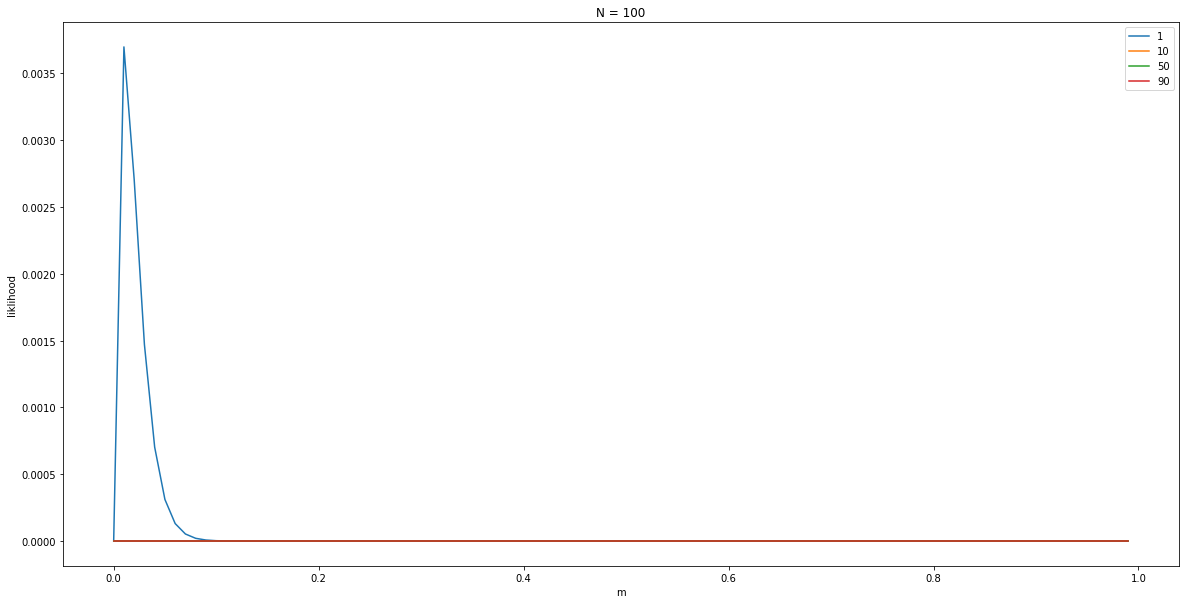

In [40]:
>>> from scipy.stats import bernoulli

x = np.arange (0, 1, 0.01)

for i in [1,2,5,9]:
    plt.plot(x,likelihood(x,10, i), label=str(i))

plt.xlabel('m')
plt.ylabel('liklihood')
plt.title('N = 10')
plt.legend(loc='best')
plt.show()

for i in [1,10,50,90]:
    plt.plot(x,likelihood(x,100, i), label=str(i))

plt.xlabel('m')
plt.ylabel('liklihood')
plt.title('N = 100')
plt.legend(loc='best')
plt.show()

**Q:** Koja vrijednost odgovara ML-procjenama i zašto?

#### (c)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za $N=10$ i $m=\{0,9\}$.

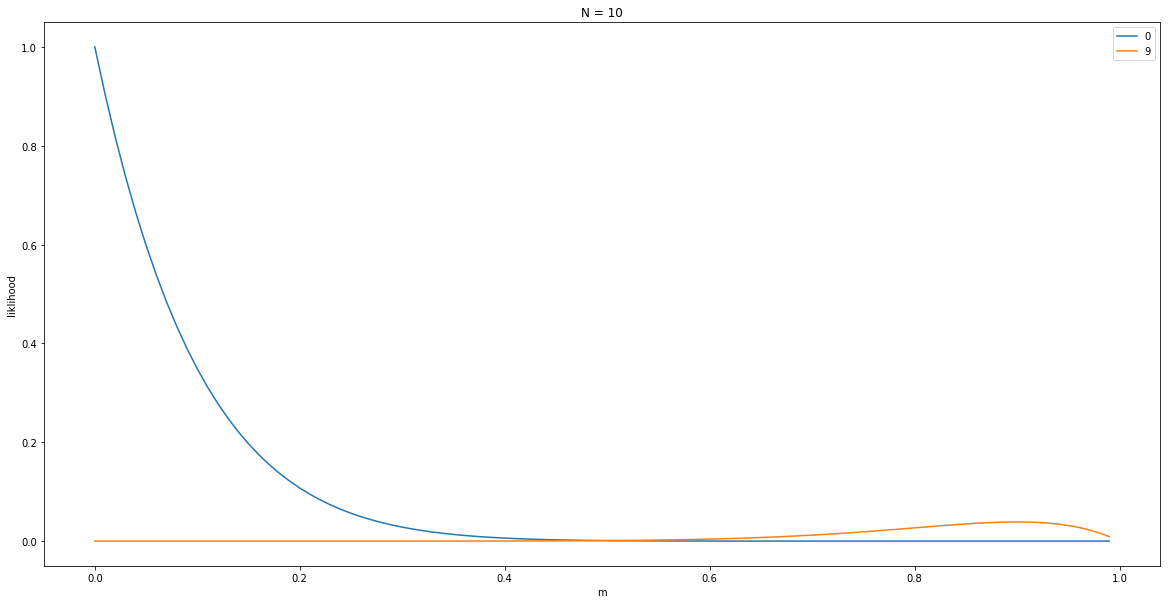

In [90]:
l2 =[]
x = np.arange (0, 1, 0.01)
for i in [0,9]:
    plt.plot(x,likelihood(x,10, i), label=str(i))

plt.xlabel('m')
plt.ylabel('liklihood')
plt.title('N = 10')
plt.legend(loc='best')
plt.show()

**Q:** Koja je ML-procjena za $\mu$ i što je problem s takvom procjenom u ovome slučaju?

#### (d)

Prikažite beta-distribuciju $B(\mu|\alpha,\beta)$ za različite kombinacije parametara $\alpha$ i $\beta$, uključivo $\alpha=\beta=1$ te $\alpha=\beta=2$.

In [53]:
def betaDist(x,alpha, beta):
    return (x**(alpha-1))*((1-x)**(beta-1))



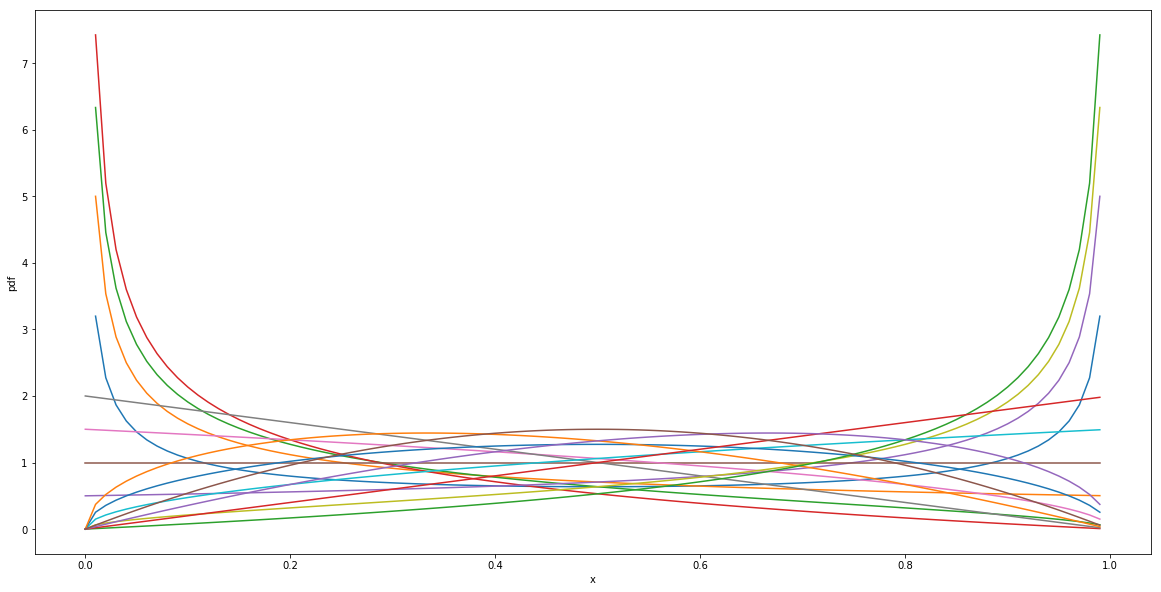

In [97]:
from scipy.stats import beta
x = np.arange (0, 1, 0.01)

for a in [  0.5, 1, 1.5, 2]:
    for b in [ 0.5, 1, 1.5, 2]:
        plt.plot(x, beta.pdf(x, a, b), label='a='+str(a)+',b='+str(b))
        
plt.xlabel('x')
plt.ylabel('pdf')
# plt.legend(loc='best')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()


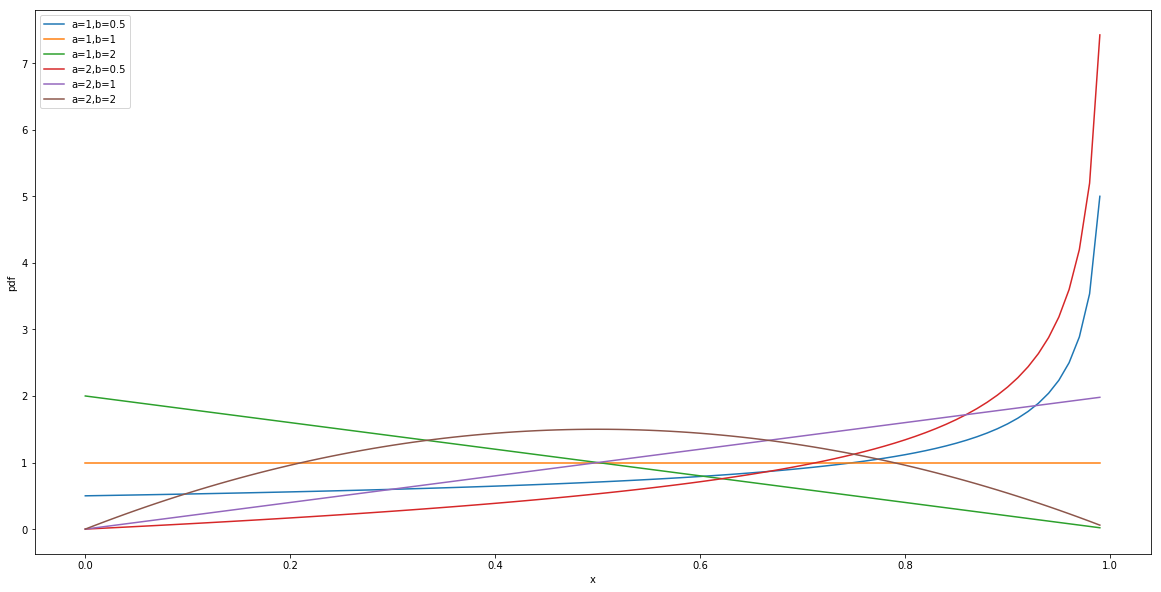

In [96]:
for a in [  1,2]:
    for b in [  0.5, 1, 2]:
        plt.plot(x, beta.pdf(x, a, b), label='a='+str(a)+',b='+str(b))
        
plt.xlabel('x')
plt.ylabel('pdf')
plt.legend(loc='best')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

**Q:** Koje parametere biste odabrali za modeliranje apriornog znanja o parametru $\mu$ za novčić za koji mislite da je "donekle pravedan, ali malo češće pada na glavu"? Koje biste parametre odabrali za novčić za koji držite da je posve pravedan? Zašto uopće koristimo beta-distribuciju, a ne neku drugu?

#### (e)

Definirajte funkciju za izračun zajedničke vjerojatnosti $P(\mu,\mathcal{D}) = P(\mathcal{D}|\mu) \cdot P(\mu|\alpha,\beta)$ te prikažite tu funkciju za $N=10$ i $m=9$ i nekolicinu kombinacija parametara $\alpha$ i $\beta$. 

C:\Users\Branko\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in multiply
C:\Users\Branko\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in multiply


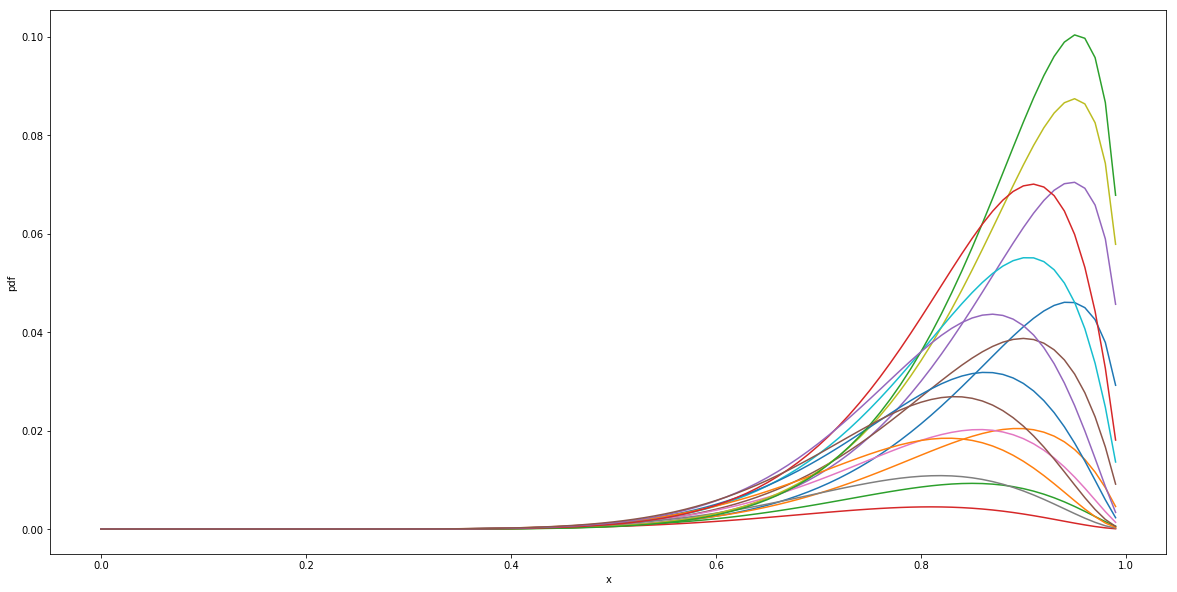

In [105]:
pylab.rcParams['figure.figsize'] = (20, 10)
x = np.arange (0, 1, 0.01)
def common_probability(mi, a, b,m, N):
    return beta.pdf(mi,a,b)*likelihood(mi,10, 9)

for a in [  0.5, 1, 1.5, 2]:
    for b in [ 0.5, 1, 1.5, 2]:
        plt.plot(x,common_probability(x,a,b,9,10), label ="a="+str(a)+ ",b="+str(b))
plt.xlabel('x')
plt.ylabel('pdf')
plt.show()

**Q**: Koje vrijednosti odgovaraju MAP-procjeni za $\mu$? Usporedite ih sa ML-procjenama.

#### (f)

Za $N=10$ i $m=1$, na jednome grafikonu prikažite sve tri distribucije: $P(\mu,\mathcal{D})$, $P(\mu|\alpha,\beta)$ i $\mathcal{L}(\mu|\mathcal{D})$.

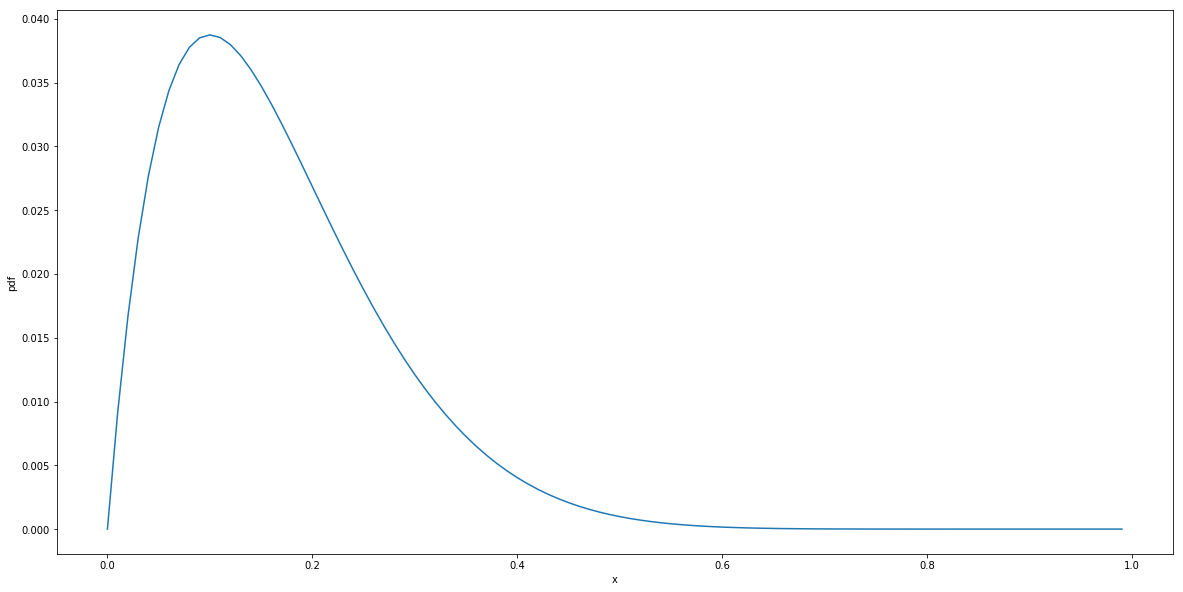

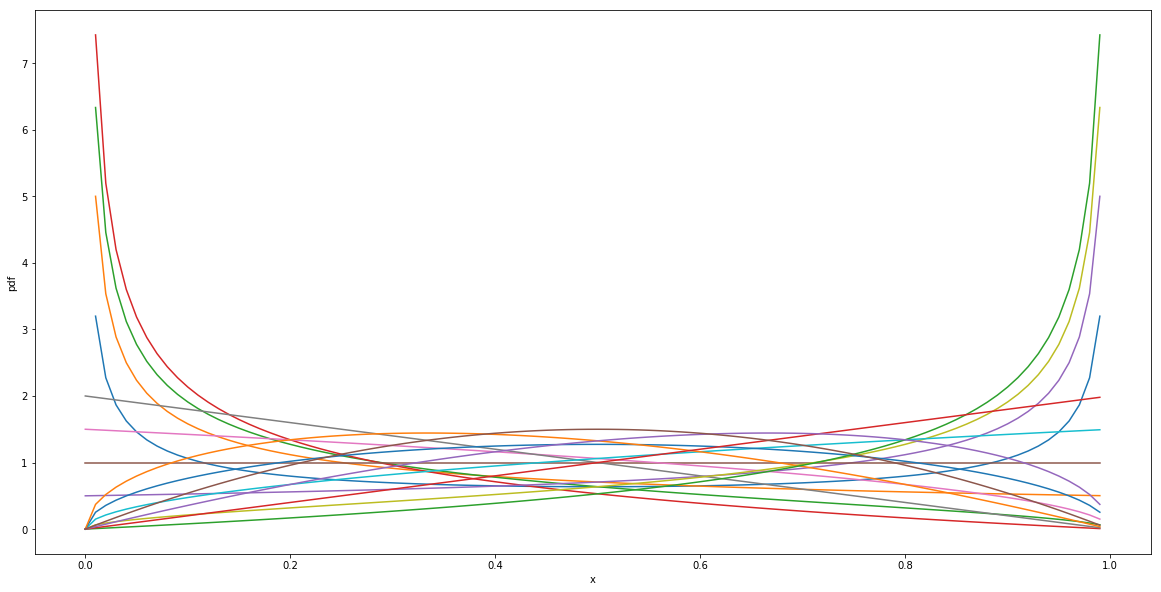

C:\Users\Branko\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: invalid value encountered in multiply


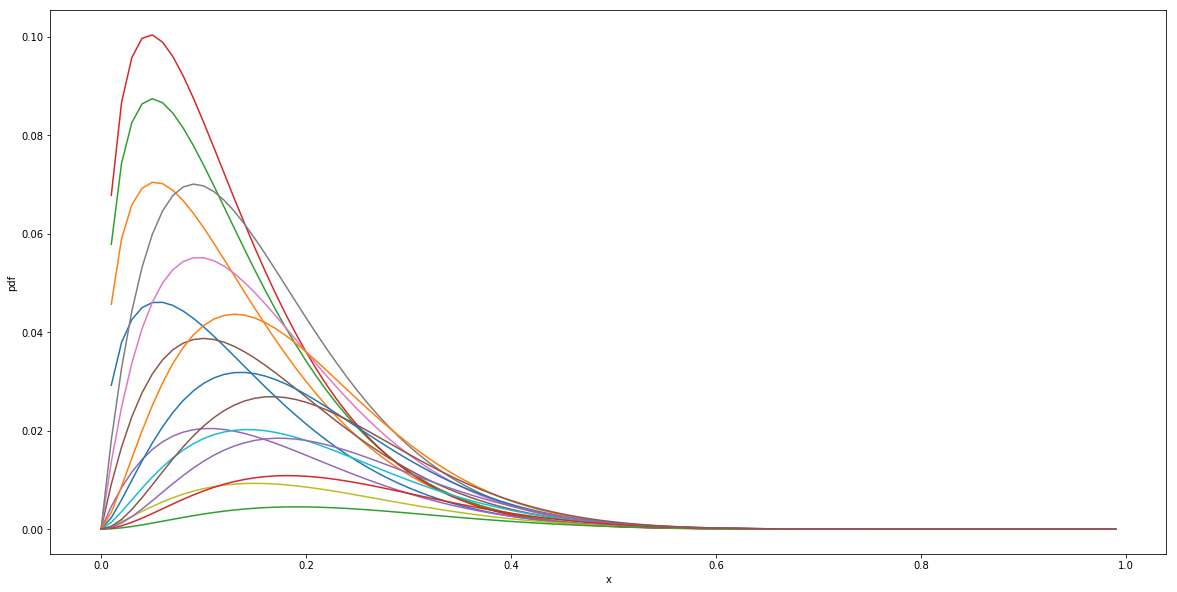

In [99]:
pylab.rcParams['figure.figsize'] = (20, 10)
x = np.arange (0, 1, 0.01)

likely = likelihood(x,10, 1)

plt.plot(x,likely)
plt.xlabel('x')
plt.ylabel('pdf')
plt.show()
for a in [  0.5, 1, 1.5, 2]:
    for b in [0.5, 1, 1.5, 2]:
        y = beta.pdf(x,a,b)
        plt.plot(x,y, label ="a="+str(a)+ ",b="+str(b))
plt.xlabel('x')
plt.ylabel('pdf')
plt.show()
for a in [ 0.5, 1, 1.5, 2]:
    for b in [ 0.5, 1, 1.5, 2]:
        y = beta.pdf(x,a,b)
        plt.plot(x,y*likely, label ="a="+str(a)+ ",b="+str(b))
plt.xlabel('x')
plt.ylabel('pdf')
plt.show()

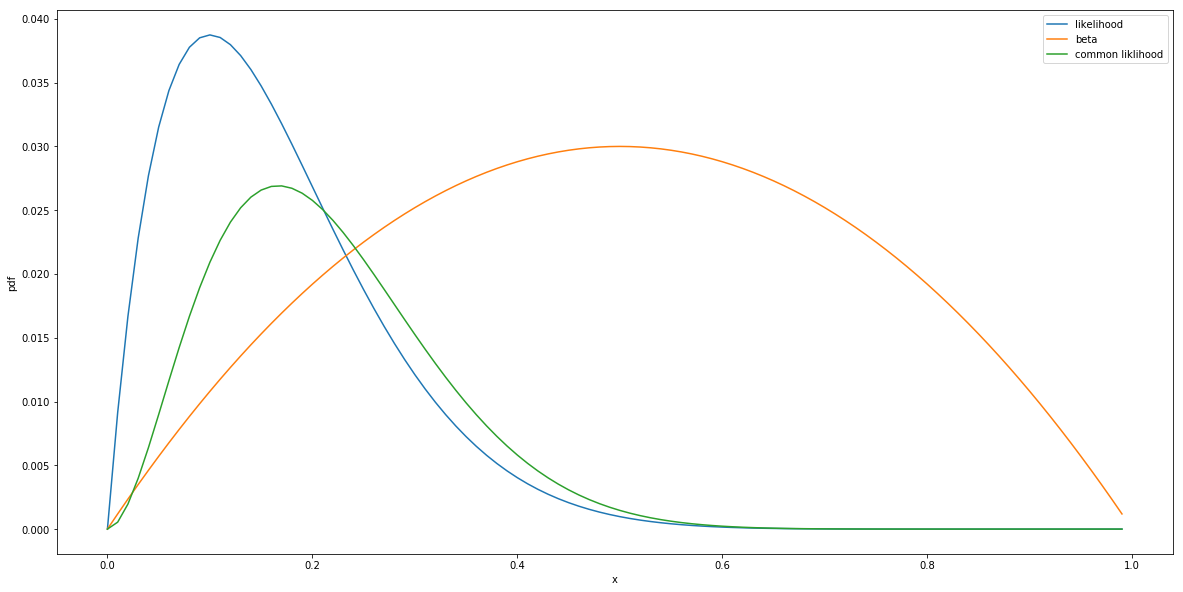

In [108]:
pylab.rcParams['figure.figsize'] = (20, 10)
x = np.arange (0, 1, 0.01)

likely = likelihood(x,10, 1)

plt.plot(x,likely,label='likelihood')


y = beta.pdf(x,2,2)
plt.plot(x,y/50, label='beta')

plt.plot(x,y*likely, label ="common liklihood")
plt.xlabel('x')
plt.ylabel('pdf')
plt.legend(loc='best')
plt.show()

#### (g)

Pročitajte [ove](http://scikit-learn.org/stable/datasets/) upute o učitavanju oglednih skupova podataka u SciPy. Učitajte skup podataka *Iris*. Taj skup sadrži $n=4$ značajke i $K=3$ klase. Odaberite jednu klasu i odaberite sve primjere iz te klase, dok ostale primjere zanemarite (**u nastavku radite isključivo s primjerima iz te jedne klase**). Vizualizirajte podatke tako da načinite 2D-prikaze za svaki par značajki (šest grafikona; za prikaz je najjednostavnije koristiti funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter)).

**NB:** Mogla bi Vam dobro dući funkcija [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations).

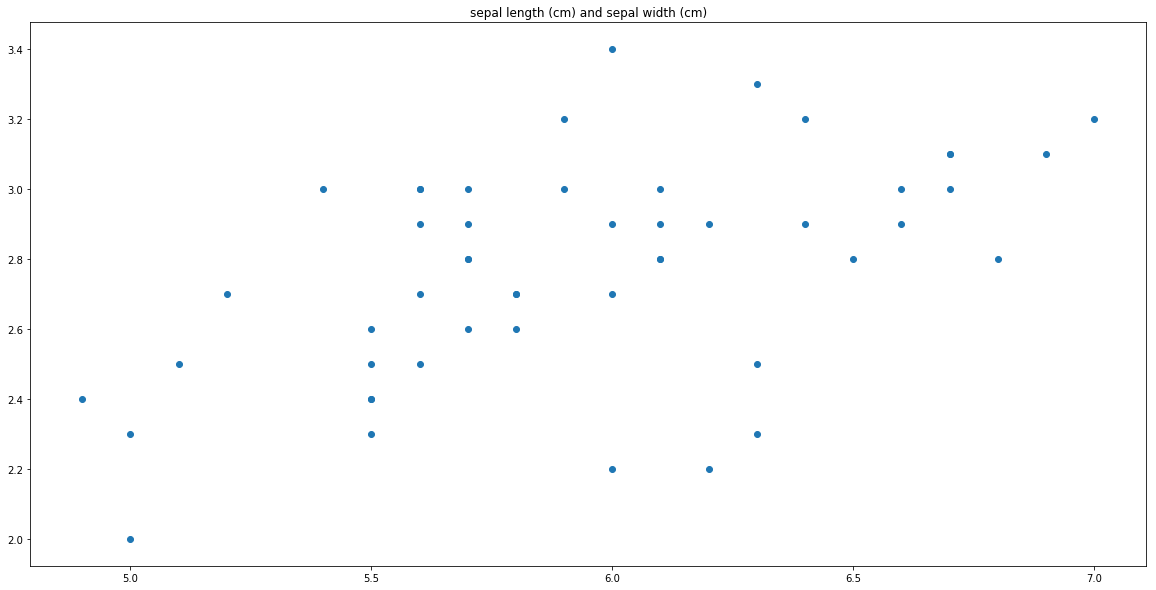

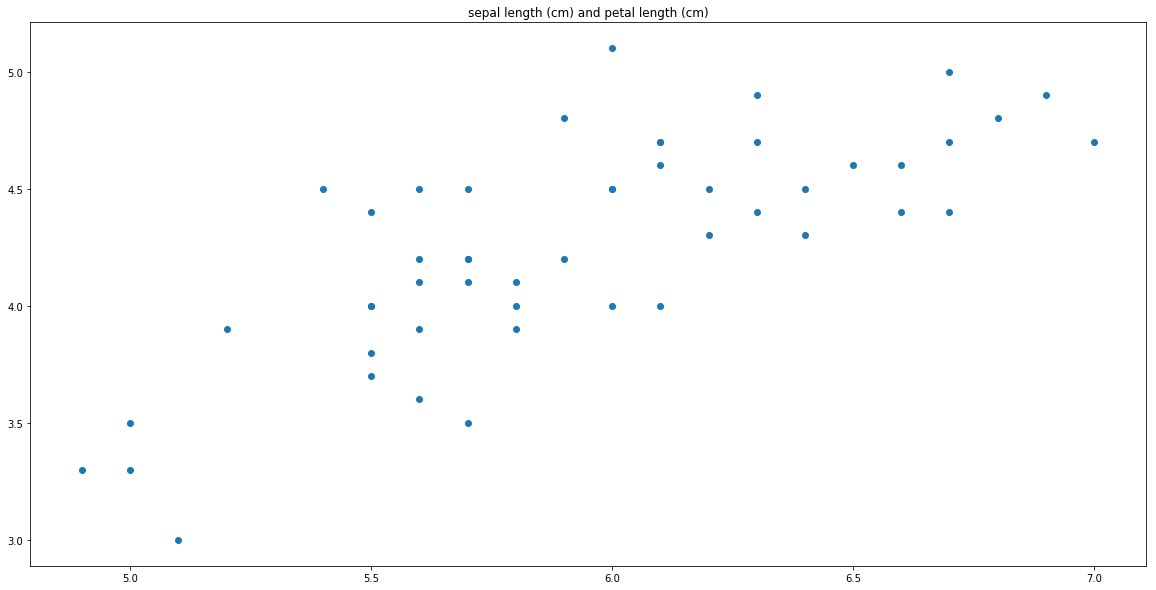

In [110]:
from sklearn.datasets import load_iris
import itertools as it

iris = load_iris()

target = []
param1 = []
param2 = []
param3 = []
param4 = []

for i in range(0, iris.target.size):
    if(iris.target[i] == 1):            
            param1.append(iris.data[i,0])
            param2.append(iris.data[i,1])
            param3.append(iris.data[i,2])
            param4.append(iris.data[i,3])
           
param1_arr = np.array(list(param1))
param2_arr = np.array(list(param2))
param3_arr = np.array(list(param3))
param4_arr = np.array(list(param4))
plt.scatter(param1_arr,param2_arr)
plt.title(iris.feature_names[0]+' and '+iris.feature_names[1])
plt.show()
plt.scatter(param1_arr,param3_arr)
plt.title(iris.feature_names[0]+' and '+iris.feature_names[2])
plt.show()

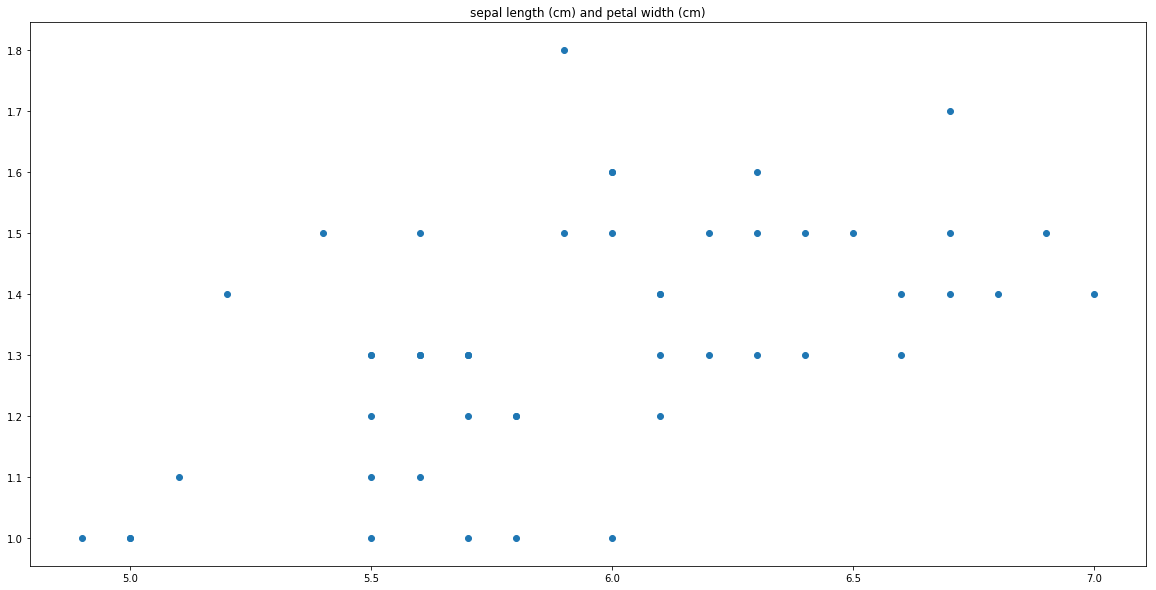

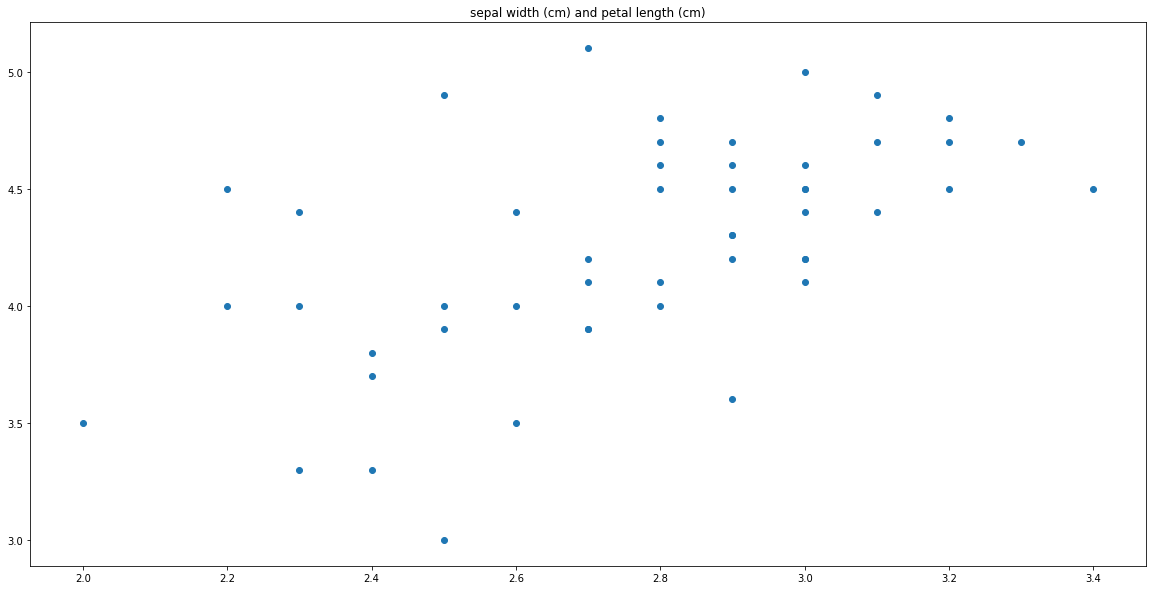

In [111]:
plt.scatter(param1_arr,param4_arr)
plt.title(iris.feature_names[0]+' and '+iris.feature_names[3])
plt.show()
plt.scatter(param2_arr,param3_arr)
plt.title(iris.feature_names[1]+' and '+iris.feature_names[2])
plt.show()

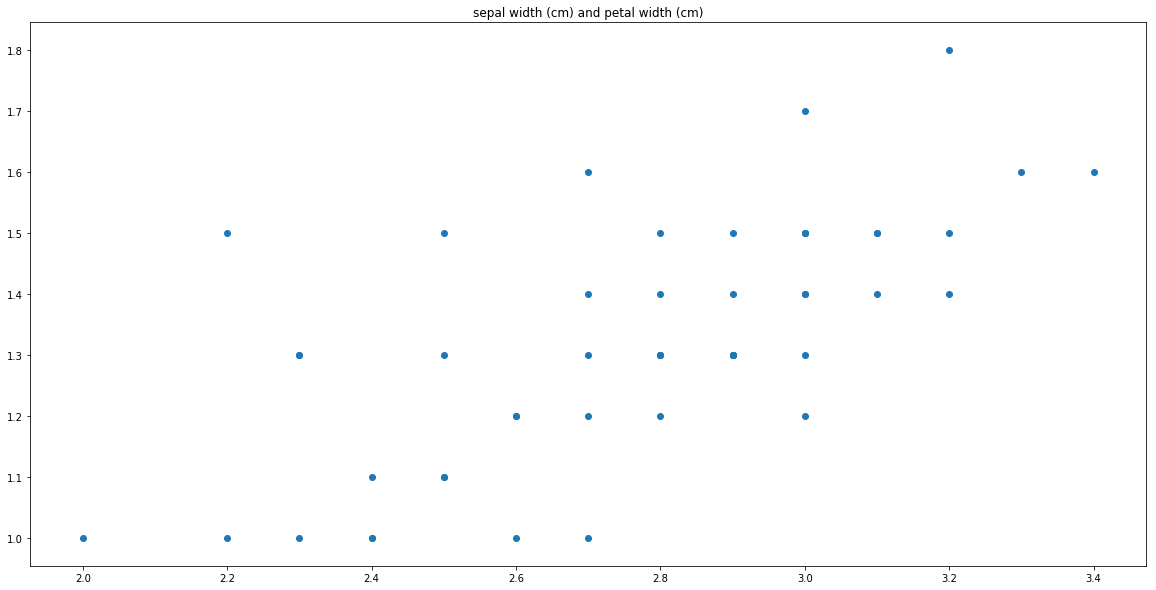

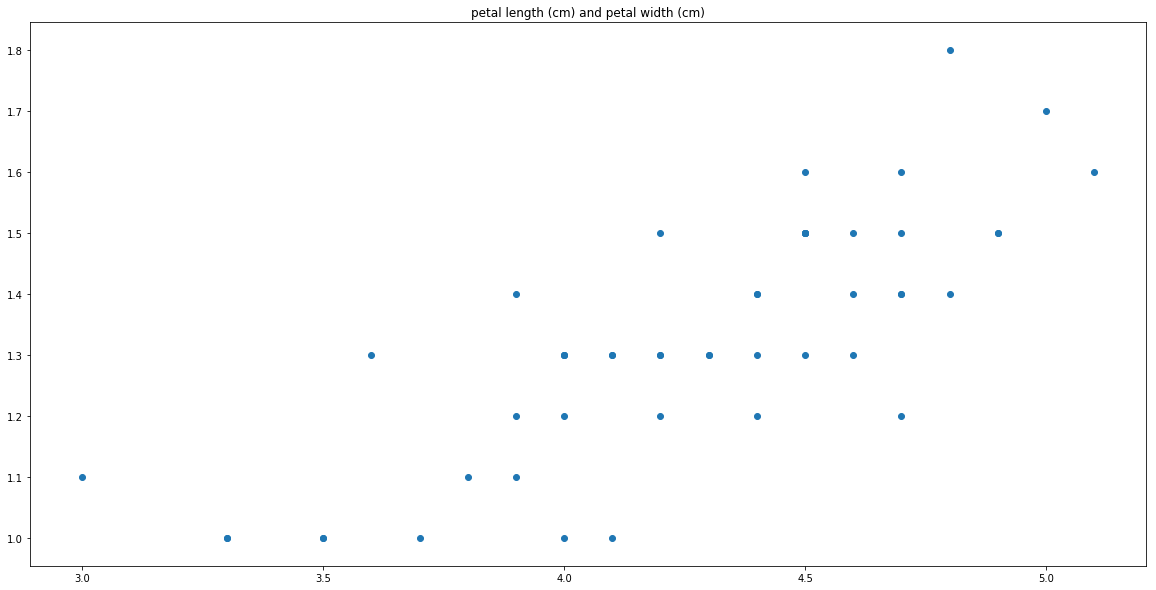

In [112]:
plt.scatter(param2_arr,param4_arr)
plt.title(iris.feature_names[1]+' and '+iris.feature_names[3])
plt.show()
plt.scatter(param3_arr,param4_arr)
plt.title(iris.feature_names[2]+' and '+iris.feature_names[3])

plt.show()

#### (h)

Implementirajte funkciju log-izglednosti za parametre $\mu$ i $\sigma^2$ normalne distribucije.

In [60]:
def ML_mean(N):
    sum = 0
    for i in range(0,N.size):
          sum +=N[i]
    return sum/N.size

def ML_var1(N):
    sum = 0
    mean = ML_mean(N)
    for i in range(0,N.size):
          sum +=(N[i]-mean)**2
    return sum/N.size

def ML_var2(N):
    sum = 0
    mean = ML_mean(N)
    for i in range(0,N.size):
          sum +=(N[i]-mean)**2
    return sum/(N.size-1)

#### (i)
Izračunajte ML-procjene za $(\mu, \sigma^2)$ za svaku od $n=4$ značajki iz skupa *Iris*. Ispišite log-izglednosti tih ML-procjena. 

In [61]:
print("{} mean is {} and variance is {} ".format(iris.feature_names[0], np.mean(iris.data[:,0]), np.var(iris.data[:,0])))
print("{} ML mean is {} and ML var1 is {} and and ML var2 is {} \n".format(iris.feature_names[0], ML_mean(iris.data[:,0]), ML_var1(iris.data[:,0]), ML_var2(iris.data[:,0])))

print("{} mean is {} and variance is {} ".format(iris.feature_names[1], np.mean(iris.data[:,1]), np.var(iris.data[:,1])))
print("{} ML mean is {} and ML var1 is {} and and ML var2 is {}\n ".format(iris.feature_names[1], ML_mean(iris.data[:,1]), ML_var1(iris.data[:,0]), ML_var2(iris.data[:,1])))

print("{} mean is {} and variance is {} ".format(iris.feature_names[2], np.mean(iris.data[:,2]), np.var(iris.data[:,2])))
print("{} ML mean is {} and ML var1 is {} and and ML var2 is {} \n".format(iris.feature_names[2], ML_mean(iris.data[:,2]), ML_var1(iris.data[:,2]), ML_var2(iris.data[:,2])))

print("{} mean is {} and variance is {} ".format(iris.feature_names[3], np.mean(iris.data[:,3]), np.var(iris.data[:,3])))
print("{} ML mean is {} and ML var1 is {} and and ML var2 is {} ".format(iris.feature_names[3], ML_mean(iris.data[:,3]), ML_var1(iris.data[:,3]), ML_var2(iris.data[:,3])))


sepal length (cm) mean is 5.843333333333334 and variance is 0.6811222222222223 
sepal length (cm) ML mean is 5.843333333333335 and ML var1 is 0.6811222222222222 and and ML var2 is 0.6856935123042505 

sepal width (cm) mean is 3.0540000000000003 and variance is 0.18675066666666668 
sepal width (cm) ML mean is 3.0540000000000007 and ML var1 is 0.6811222222222222 and and ML var2 is 0.18800402684563763
 
petal length (cm) mean is 3.758666666666666 and variance is 3.092424888888889 
petal length (cm) ML mean is 3.7586666666666693 and ML var1 is 3.0924248888888854 and and ML var2 is 3.1131794183445156 

petal width (cm) mean is 1.1986666666666668 and variance is 0.5785315555555555 
petal width (cm) ML mean is 1.1986666666666672 and ML var1 is 0.5785315555555559 and and ML var2 is 0.5824143176733784 


**Q:** Možete li, na temelju dobivenih log-izglednosti, zaključiti koja se značajka najbolje pokorava normalnoj distribuciji? 

#### (j)

Proučite funkciju [`pearsonr`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) za izračun Pearsonovog koeficijenta korelacije. Izračunajte koeficijente korelacije između svih četiri značajki u skupu *Iris*. 

In [62]:
from scipy.stats import pearsonr

print("corellation {} and {} is {}\n".format(iris.feature_names[0],iris.feature_names[1],pearsonr(iris.data[:,0],iris.data[:,1])))
print("corellation {} and {} is {}\n".format(iris.feature_names[0],iris.feature_names[2],pearsonr(iris.data[:,0],iris.data[:,2])))
print("corellation {} and {} is {}\n".format(iris.feature_names[0],iris.feature_names[3],pearsonr(iris.data[:,0],iris.data[:,3])))
print("corellation {} and {} is {}\n".format(iris.feature_names[1],iris.feature_names[2],pearsonr(iris.data[:,1],iris.data[:,2])))
print("corellation {} and {} is {}\n".format(iris.feature_names[1],iris.feature_names[3],pearsonr(iris.data[:,1],iris.data[:,3])))
print("corellation {} and {} is {}\n".format(iris.feature_names[2],iris.feature_names[3],pearsonr(iris.data[:,2],iris.data[:,3])))

corellation sepal length (cm) and sepal width (cm) is (-0.10936924995064935, 0.18276521527136649)

corellation sepal length (cm) and petal length (cm) is (0.87175415730487116, 1.0384540627941809e-47)

corellation sepal length (cm) and petal width (cm) is (0.81795363336916327, 2.3148491512729807e-37)

corellation sepal width (cm) and petal length (cm) is (-0.42051609640115445, 8.4293663929502784e-08)

corellation sepal width (cm) and petal width (cm) is (-0.3565440896138059, 7.5238909560674415e-06)

corellation petal length (cm) and petal width (cm) is (0.96275709705096624, 5.776660988495158e-86)



#### (k)

Proučite funkciju [`cov`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) te izračunajte ML-procjenu za kovarijacijsku matricu za skup *Iris*. Usporedite pristranu i nepristranu procjenu. Pokažite da se razlika (srednja apsolutna i kvadratna) smanjuje s brojem primjera (npr. isprobajte za $N/4$ i $N/2$ i $N$ primjera).

In [63]:
n, m = iris.data.shape
print("cov for N \n{}\n".format(np.cov(np.transpose(iris.data))))
print("cov for N/2 \n{}\n".format(np.cov(np.transpose(iris.data[0:int(n/2),:]))))
print("cov for N/4 \n{}\n".format(np.cov(np.transpose(iris.data[0:int(n/4),:]))))

a = np.array([ML_mean(iris.data[:,0]),ML_mean(iris.data[:,1]),ML_mean(iris.data[:,2]),ML_mean(iris.data[:,3])])
mean_mat = np.tile(a,(n,1))
ML_cov1 = np.matmul(np.transpose(iris.data-mean_mat),(iris.data-mean_mat))/n
print("With bias ML cov for N\n {} \n ".format(ML_cov1))

a = np.array([ML_mean(iris.data[:int(n/2),0]),ML_mean(iris.data[:int(n/2),1]),ML_mean(iris.data[:int(n/2),2]),ML_mean(iris.data[:int(n/2),3])])
mean_mat = np.tile(a,(int(n/2),1))
ML_cov2 = 2*np.matmul(np.transpose(iris.data[:int(n/2),:]-mean_mat),(iris.data[:int(n/2),:]-mean_mat))/n
print("With bias ML cov for N/2 \n{} \n ".format(ML_cov2))

a = np.array([ML_mean(iris.data[:int(n/4),0]),ML_mean(iris.data[:int(n/4),1]),ML_mean(iris.data[:int(n/4),2]),ML_mean(iris.data[:int(n/4),3])])
mean_mat = np.tile(a,(int(n/4),1))
ML_cov3 = 4*np.matmul(np.transpose(iris.data[:int(n/4),:]-mean_mat),(iris.data[:int(n/4),:]-mean_mat))/n
print("With bias ML cov for N/4 \n{} \n ".format(ML_cov3))

a = np.array([ML_mean(iris.data[:,0]),ML_mean(iris.data[:,1]),ML_mean(iris.data[:,2]),ML_mean(iris.data[:,3])])
mean_mat = np.tile(a,(n,1))
ML_cov4 = np.matmul(np.transpose(iris.data-mean_mat),(iris.data-mean_mat))/(n-1)
print("Without bias ML cov for N\n {} \n ".format(ML_cov4))

a = np.array([ML_mean(iris.data[:int(n/2),0]),ML_mean(iris.data[:int(n/2),1]),ML_mean(iris.data[:int(n/2),2]),ML_mean(iris.data[:int(n/2),3])])
mean_mat = np.tile(a,(int(n/2),1))
ML_cov5 = np.matmul(np.transpose(iris.data[:int(n/2),:]-mean_mat),(iris.data[:int(n/2),:]-mean_mat))/(n/2-1)
print("Without bias ML cov for N/2 \n{} \n ".format(ML_cov5))

a = np.array([ML_mean(iris.data[:int(n/4),0]),ML_mean(iris.data[:int(n/4),1]),ML_mean(iris.data[:int(n/4),2]),ML_mean(iris.data[:int(n/4),3])])
mean_mat = np.tile(a,(int(n/4),1))
ML_cov6 = np.matmul(np.transpose(iris.data[:int(n/4),:]-mean_mat),(iris.data[:int(n/4),:]-mean_mat))/(n/4-1)
print("Without bias ML cov for N/4 \n{} \n ".format(ML_cov6))

m1 = ML_cov4-ML_cov5
m2 = ML_cov4-ML_cov6
print("square difference between N and N/2 \n{} \n\n and apsolute \n{}\n".format(np.multiply(m1,m1), np.abs(m1)))
print("square difference between N and N/2 \n{} \n\n and apsolute \n{}".format(np.multiply(m2,m2), np.abs(m2)))

cov for N 
[[ 0.68569351 -0.03926846  1.27368233  0.5169038 ]
 [-0.03926846  0.18800403 -0.32171275 -0.11798121]
 [ 1.27368233 -0.32171275  3.11317942  1.29638747]
 [ 0.5169038  -0.11798121  1.29638747  0.58241432]]

cov for N/2 
[[ 0.40759279 -0.04354595  0.71646847  0.27306667]
 [-0.04354595  0.22930811 -0.37532432 -0.13639459]
 [ 0.71646847 -0.37532432  1.91063063  0.73012613]
 [ 0.27306667 -0.13639459  0.73012613  0.29393874]]

cov for N/4 
[[ 0.12974474  0.09776276  0.01121622  0.01362613]
 [ 0.09776276  0.13463964  0.00057808  0.01397147]
 [ 0.01121622  0.00057808  0.03123123  0.00497748]
 [ 0.01362613  0.01397147  0.00497748  0.0101952 ]]

With bias ML cov for N
 [[ 0.68112222 -0.03900667  1.26519111  0.51345778]
 [-0.03900667  0.18675067 -0.319568   -0.11719467]
 [ 1.26519111 -0.319568    3.09242489  1.28774489]
 [ 0.51345778 -0.11719467  1.28774489  0.57853156]] 
 
With bias ML cov for N/2 
[[ 0.40215822 -0.04296533  0.70691556  0.26942578]
 [-0.04296533  0.22625067 -0.37032  